In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
from qutip import *
import random
from numpy.random import choice
import matplotlib.cm as cm
from sympy import *
from IPython.display import Image
from sympy.physics.wigner import wigner_6j
from sympy.physics.quantum.cg import CG
import tqdm
from numpy import random
from scipy.optimize import curve_fit

""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
hbar = sp.constants.hbar
h = sp.constants.h
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

In [2]:
#hyperfine reduced matrix element <F||d||F'>
def __Fg_d_Fe(Jg_d_Je, Fg, Fe, Jg, Je, I):
    return (
    Jg_d_Je * (-1)**(Fe+Jg+1+I) * 
        np.sqrt( (2*Fe+1)*(2*Jg+1) ) 
        * wigner_6j(Jg, Je, 1, Fe, Fg, I)
    )

In [3]:
#reduced matrix element <Jg||d||Je>
def __Jg_d_Je(omega_0, Jg, Je, tau):
    return np.sqrt(
        3*np.pi*epsilon0*hbar*c**3/omega_0**3/tau
        * (2*Je+1)/(2*Jg+1)
    )

In [4]:
def Rabi(Fg, Fe, mg, me, Jg, Je, I, omega_0, tau, pol):
    q = -(me-mg)
    Jg_d_Je = __Jg_d_Je(omega_0, Jg, Je, tau)
    
    CG_coeff = float(CG(Fe, me, 1, q, Fg, mg).doit())
    
    Eplus = pol * np.sqrt( intensity / 2 / epsilon0 / c)
    
    return (
    -2 * Jg_d_Je / hbar * Eplus *
        (-1)**(Fe+Jg+1+I) * np.sqrt( (2*Fe+1)*(2*Jg+1) ) * CG_coeff * 
        float(wigner_6j(Je, Jg, 1, Fg, Fe, I))
    )

In [5]:
def cos_fit(t, f, phi):
    return -np.cos(2*np.pi*t*f+phi)*1/2+1/2

In [6]:
_lambda = 556e-9
m = 171*u
omega_0 =  2*np.pi*(4760.247 + 539385645.457)*1e6 
#https://journals.aps.org/pra/pdf/10.1103/PhysRevA.100.042505
tau = 866.1e-9

#total intensity at the atom
wV = 0.055e-3
wH = 1.3e-3
Ptot = 562e-3
intensity = 2*Ptot/np.pi/wV/wH

In [7]:
Fg = 1/2
Je = 1
Jg = 0
I = 1/2
Le = 1
Se = 1

Fe_12 = 1/2
Fe_32 = 3/2

In [8]:
one = basis(8,0) #1S0 mF=-1/2
two = basis(8,1) #1S0 mF=+1/2
three = basis(8,2) #F=1/2 3P1 mF=-1/2
four = basis(8,3) #F=1/2 3P1 mF=+1/2
five = basis(8,4) #F=3/2 3P1 mF=-3/2
six = basis(8,5) #F=3/2 3P1 mF=-1/2
seven = basis(8, 6) #F=3/2 3P1 mF=+1/2
eight = basis(8, 7) #F=3/2 3P1 mF=+3/2

sig_11 = one*one.dag()
sig_22 = two*two.dag()
sig_33 = three*three.dag()
sig_44 = four*four.dag()
sig_55 = five*five.dag()
sig_66 = six*six.dag()
sig_77 = seven*seven.dag()
sig_88 = eight*eight.dag()


#connections from 1S0 mF=-1/2
sig_13 = one*three.dag()
sig_31 = three*one.dag()

sig_14 = one*four.dag()
sig_41 = four*one.dag()

sig_51 = five*one.dag()
sig_15 = one*five.dag()

sig_61 = six*one.dag()
sig_16 = one*six.dag()

sig_71 = seven*one.dag()
sig_17 = one*seven.dag()


#connections from 1S0 mF=+1/2
sig_23 = two*three.dag()
sig_32 = three*two.dag()

sig_24 = two*four.dag()
sig_42 = four*two.dag()

sig_62 = six*two.dag()
sig_26 = two*six.dag()

sig_72 = seven*two.dag()
sig_27 = two*seven.dag()

sig_82 = eight*two.dag()
sig_28 = two*eight.dag()

In [9]:
psi0 = two

## As a function of B field

In [10]:
Delta_12 = -2*np.pi*6e9 #detuning from the free space resonance of F=1/2
Delta_32 = Delta_12-2*np.pi*6e9 #detuning from the free space resonance of F=3/2

In [13]:
phi = np.pi/2

#total intensity at the atom
wV = 0.055e-3
wH = 1.3e-3
Ptot = 562e-3*0.5
intensity = 2*Ptot/np.pi/wV/wH

LS_ls = []

B_ls = np.linspace(0, 30, 100)*1e-4

for B in B_ls:
    
    #Zeeman shifts

    gJe = 3/2 + (Se*(Se+1) - Le*(Le+1)) / 2 / Je / (Je+1)  
    gFe_12 = (Fe_12*(Fe_12+1) + Je*(Je+1) - I*(I+1)) / 2 / Fe_12 / (Fe_12+1) * gJe
    gFe_32 = (Fe_32*(Fe_32+1) + Je*(Je+1) - I*(I+1)) / 2 / Fe_32 / (Fe_32+1) * gJe


    delta_N = -2*np.pi*750*B*1e4 #nuclear states splitting

    Delta_g1 = -delta_N/2
    Delta_g2 = delta_N/2

    Delta_e3 = -1/2*gFe_12*mB*B / hbar
    Delta_e4 = 1/2*gFe_12*mB*B / hbar
    Delta_e5 = -3/2*gFe_32*mB*B / hbar
    Delta_e6 = -1/2*gFe_32*mB*B / hbar
    Delta_e7 = 1/2*gFe_32*mB*B / hbar
    Delta_e8 = 3/2*gFe_32*mB*B / hbar
    
    #diagonal terms
    diag_1 = Delta_g1
    diag_2 = Delta_g2

    diag_3 = -Delta_12 + Delta_e3
    diag_4 = -Delta_12 + Delta_e4

    diag_5 = -Delta_32 + Delta_e5
    diag_6 = -Delta_32 + Delta_e6
    diag_7 = -Delta_32 + Delta_e7
    diag_8 = -Delta_32 + Delta_e8
    

    ## polarization ##
    ##################

    #basis
    x = np.array([1,0,0])
    y = np.array([0,1,0])
    z = np.array([0,0,1])

    polarization = 1/np.sqrt(2)*(y+np.exp(-1j*phi)*z)

    #spherical tensor
    pi_pol = y
    sigp_pol = 1/np.sqrt(2)*(z-1j*x)
    sigm_pol = -1/np.sqrt(2)*(z+1j*x)
    
    #off-diagonal terms
    offdiag_31 = Rabi(Fg, Fe_12, -1/2, -1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, pi_pol)) / 2
    offdiag_41 = Rabi(Fg, Fe_12, -1/2, 1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigp_pol)) / 2
    offdiag_32 = Rabi(Fg, Fe_12, 1/2, -1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigm_pol)) / 2
    offdiag_42 = Rabi(Fg, Fe_12, 1/2, 1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, pi_pol)) / 2

    offdiag_51 = Rabi(Fg, Fe_32, -1/2, -3/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigm_pol)) / 2
    offdiag_61 = Rabi(Fg, Fe_32, -1/2, -1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, pi_pol)) / 2
    offdiag_71 = Rabi(Fg, Fe_32, -1/2, 1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigp_pol)) / 2
    
    offdiag_62 = Rabi(Fg, Fe_32, 1/2, -1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigm_pol)) / 2
    offdiag_72 = Rabi(Fg, Fe_32, 1/2, 1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, pi_pol)) / 2
    offdiag_82 = Rabi(Fg, Fe_32, 1/2, 3/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigp_pol)) / 2

    offdiag_13 = np.conjugate(offdiag_31)
    offdiag_14 = np.conjugate(offdiag_41)
    offdiag_23 = np.conjugate(offdiag_32)
    offdiag_24 = np.conjugate(offdiag_42)

    offdiag_15 = np.conjugate(offdiag_51)
    offdiag_16 = np.conjugate(offdiag_61)
    offdiag_17 = np.conjugate(offdiag_71)
    
    offdiag_26 = np.conjugate(offdiag_62)
    offdiag_27 = np.conjugate(offdiag_72)
    offdiag_28 = np.conjugate(offdiag_82)

    LS1 = (offdiag_31*offdiag_13/(2*Delta_12-2*Delta_e3) + 
           offdiag_41*offdiag_14/(2*Delta_12-2*Delta_e4) + 
           offdiag_51*offdiag_15/(2*Delta_32-2*Delta_e5) + 
           offdiag_61*offdiag_16/(2*Delta_32-2*Delta_e6) + 
           offdiag_71*offdiag_17/(2*Delta_32-2*Delta_e7) 
          +Delta_g1
          )

    LS2 = (offdiag_32*offdiag_23/(2*Delta_12-2*Delta_e3) + 
       offdiag_42*offdiag_24/(2*Delta_12-2*Delta_e4) + 
       offdiag_62*offdiag_26/(2*Delta_32-2*Delta_e6) + 
       offdiag_72*offdiag_27/(2*Delta_32-2*Delta_e7) + 
       offdiag_82*offdiag_28/(2*Delta_32-2*Delta_e8) 
       + Delta_g2
     )
    
    
    LS_ls.append(LS1-LS2)

C:\Users\klab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'ground state splitting (kHz)')

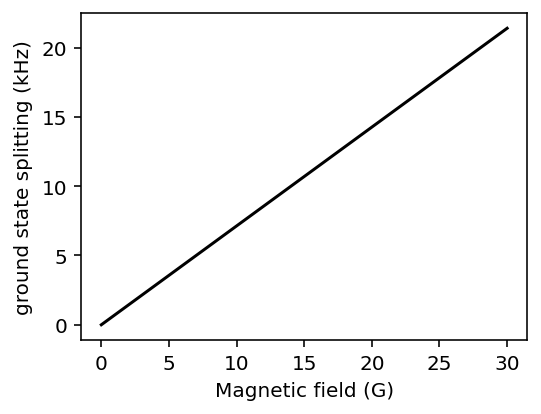

In [14]:
plt.figure(dpi=144, figsize=(4,3))

plt.plot(np.array(B_ls)*1e4, np.array(LS_ls)/1e3/2/np.pi, 'k-')
plt.xlabel('Magnetic field (G)')
plt.ylabel('ground state splitting (kHz)')
#plt.ylim(0,)

In [15]:
Delta_g1

7.690618815987815

The bare atomic hamiltonian is:
 $$H_0 =
\begin{align*}
        \begin{pmatrix} 
        -\delta_N/2 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ 
        0 & \delta_N/2 & 0 & 0 & 0 & 0 & 0 & 0\\ 
        0 & 0 & \omega_3-\omega_1 & 0 & 0 & 0 & 0 & 0\\
        0 & 0 & 0 & \omega_4-\omega_1 & 0 & 0 & 0 & 0\\
        0 & 0 & 0 & 0 &\omega_5-\omega_1 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & \omega_6-\omega_1 & 0 & 0\\
        0 & 0 & 0 & 0 & 0 & 0 & \omega_7-\omega_1 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & \omega_8-\omega_1\\
        \end{pmatrix} \\
\end{align*}$$

The atom-field interaction hamiltonian is:

$$H_{int} = \frac{1}{2}
\begin{align*}
        \begin{pmatrix} 
        0 & 0 & \Omega_{31}^*(e^{-i\omega t} + e^{i\omega t}) & \Omega_{41}^*(e^{-i\omega t} + e^{i\omega t}) & \Omega_{51}^*(e^{-i\omega t} + e^{i\omega t}) & \Omega_{61}^*(e^{-i\omega t} + e^{i\omega t}) & \Omega_{71}^*(e^{-i\omega t} + e^{i\omega t}) & 0\\ 
        0 & 0 & \Omega_{32}^*(e^{-i\omega t} + e^{i\omega t}) & \Omega_{42}^*(e^{-i\omega t} + e^{i\omega t}) & 0 & \Omega_{62}^*(e^{-i\omega t} + e^{i\omega t}) & \Omega_{72}^*(e^{-i\omega t} + e^{i\omega t}) & \Omega_{82}^*(e^{-i\omega t} + e^{i\omega t}) \\ 
        \Omega_{31}(e^{-i\omega t} + e^{i\omega t }) & \Omega_{32}(e^{-i\omega t} + e^{i\omega t }) & 0 & 0 & 0 & 0 & 0 & 0\\
        \Omega_{41}(e^{-i\omega t} + e^{i\omega t }) & \Omega_{42}(e^{-i\omega t} + e^{i\omega t }) & 0 & 0 & 0 & 0 & 0 & 0\\
        \Omega_{51}(e^{-i\omega t} + e^{i\omega t }) & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
        \Omega_{61}(e^{-i\omega t} + e^{i\omega t }) & \Omega_{62}(e^{-i\omega t} + e^{i\omega t }) & 0 & 0 & 0 &  & 0 & 0\\
        \Omega_{71}(e^{-i\omega t} + e^{i\omega t }) & \Omega_{72}(e^{-i\omega t} + e^{i\omega t }) & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & \Omega_{82}(e^{-i\omega t} + e^{i\omega t }) & 0 & 0 & 0 & 0 & 0 & 0\\
        \end{pmatrix} \\
\end{align*}$$

.

Also suppose $\omega_0$ is the free space resonance for F=1/2. 
- $\omega = \omega_0 + \Delta_{12}$.
- $\omega_3 - \omega_1 = \omega_0 + \delta_N/2 + \Delta_{e3}$
- $\omega_4 - \omega_1 = \omega_0 + \delta_N/2 + \Delta_{e4}$
- $\omega_5 - \omega_1 = \omega_0 + \delta_N/2 + \Delta_{e5}$
- $\omega_6 - \omega_1 = \omega_0 + \delta_N/2 + \Delta_{e6}$
- $\omega_7 - \omega_1 = \omega_0 + \delta_N/2 + \Delta_{e7}$
- $\omega_8 - \omega_1 = \omega_0 + \delta_N/2 + \Delta_{e8}$

We allow detunning $\Delta$ to be positive for blue and negative for red detuning. The Zeeman shifts $\Delta_{e2,3}$ and $\delta_N/2$ can be +ve/-ve as well.

$$H_0 =
\begin{align*}
        \begin{pmatrix} 
        0 & 0 & 0 & 0\\ 
        0 & \omega_0 + \delta_N/2 + \Delta_{e2} & 0 & 0 \\
        0 & 0 & \omega_0 + \delta_N/2 + \Delta_{e3} & 0\\
        0 & 0 & 0 & \delta_N
        \end{pmatrix} \\
\end{align*}$$

$$H_{int} = \frac{1}{2}
\begin{align*}
        \begin{pmatrix} 
        0 & \Omega_{21}^*(e^{-i(\omega_0+\Delta+\delta) t} + e^{i(\omega_0+\Delta+\delta) t }) & \Omega_{31}^*(e^{-(i\omega_0+\Delta) t} + e^{i(\omega_0+\Delta) t}) & 0\\ 
        \Omega_{21}(e^{-i(\omega_0+\Delta+\delta) t} + e^{i(\omega_0+\Delta+\delta) t}) & 0 & 0 & \Omega_{24}(e^{-i(\omega_0+\Delta) t} + e^{i(\omega_0+\Delta) t}) \\
        \Omega_{31}(e^{-i(\omega_0+\Delta) t} + e^{i(\omega_0+\Delta) t}) & 0 & 0 & \Omega_{34}(e^{-i(\omega_0+\Delta+\delta) t} + e^{i(\omega_0+\Delta+\delta) t })\\
        0 & \Omega_{24}^*(e^{-i(\omega_0+\Delta) t} + e^{i(\omega_0+\Delta) t}) & \Omega_{34}^*(e^{-i(\omega_0+\Delta+\delta) t +} + e^{i(\omega_0+\Delta+\delta) t }) & 0
        \end{pmatrix} \\
\end{align*} \\
 $$

We now move to the rotating frame via
$$U =
\begin{align*}
        \begin{pmatrix} 
        I & 0 & 0 & 0\\ 
        0 & e^{-i(\omega_0 + \Delta + \delta) t} & 0 & 0 \\
        0 & 0 & e^{-i(\omega_0 + \Delta) t} & 0\\
        0 & 0 & 0 & I
        \end{pmatrix} \\
\end{align*} \\
 $$
 and apply RWA to $H_{int}$.

 $$H_0 =
\begin{align*}
        \begin{pmatrix} 
        0 & 0 & 0 & 0\\ 
        0 & -\Delta + \delta_N/2 + \Delta_{e2} -\delta & 0 & 0 \\
        0 & 0 & -\Delta + \delta_N/2 + \Delta_{e3} & 0\\
        0 & 0 & 0 & \delta_N
        \end{pmatrix} \\
\end{align*}$$

The full Hamniltonian is 
$$H = \frac{1}{2}
\begin{align*}
        \begin{pmatrix} 
        0 & \Omega_{21}^* & \Omega_{31}^* & 0\\ 
        \Omega_{21} & -2\Delta + \delta_N + 2\Delta_{e2} -2\delta & 0 & \Omega_{24}e^{i\delta t} \\
        \Omega_{31} & 0 & -2\Delta + \delta_N + 2\Delta_{e3} & \Omega_{34}e^{-i\delta t}\\
        0 & \Omega_{24}^* e^{-i\delta t}& \Omega_{34}^* e^{i\delta t} & 2\delta_N
        \end{pmatrix} \\
\end{align*} \\
 $$



Plugging those to the Schrodinger equation, gives the differential equations for the amplitude coefficients:
$$ \begin{matrix} 
i\dot{C_1} = \frac{1}{2}(\Omega_{21}^* C_2  + \Omega_{31}^* C_3)\\
i\dot{C_2} = \frac{1}{2}\Omega_{21}C_1 + \frac{1}{2}(-2\Delta +2\Delta_{e2}+\delta_N - 2\delta)C_2 + \frac{1}{2}\Omega_{24}e^{i \delta t}C_4 \\
i\dot{C_3} = \frac{1}{2}\Omega_{31}C_1 + \frac{1}{2}(-2\Delta +2\Delta_{e3}+\delta_N)C_3 + \frac{1}{2}\Omega_{34}e^{-i \delta t}C_4 \\
i\dot{C_4} = \frac{1}{2}\Omega_{24}^*e^{-i \delta t}C_2 + \frac{1}{2}\Omega_{34}^*e^{i \delta t }C_3 + \delta_N C_4\\
\end{matrix} .$$

Since $\Delta\gg\Omega$, $C_{2,3}$ oscillates at much higher frequencies than $C_{1,4}$. We can assume those oscillations average out on the timescales we are concerned about and take $C_{2,3}$ to be constant. 
$$ \begin{matrix} 
C_2 = \frac{\Omega_{21}C_1 + \Omega_{24}e^{i \delta t}C_4}{2\Delta- 2\Delta_{e2}-\delta_N + 2\delta} \\
C_3 = \frac{\Omega_{31}C_1 + \Omega_{34}e^{-i \delta t}C_4}{2\Delta -2\Delta_{e3}-\delta_N} \\
\end{matrix} .$$

This allows us to solve for $C_{1,4}$.
$$ \begin{matrix} 
i\dot{C_1} = (\frac{\Omega_{21}^*\Omega_{21}}{2(2\Delta-2\Delta_{e2}-\delta_N+2\delta)} 
+ \frac{\Omega_{31}^*\Omega_{31}}{2(2\Delta-2\Delta_{e3}-\delta_N)})C_1  + (\frac{\Omega_{21}^*\Omega_{24} e^{i\delta t}}{2(2\Delta-2\Delta_{e2}-\delta_N+2\delta)}+ 
\frac{\Omega_{31}^*\Omega_{34} e^{-i\delta t }}{2(2\Delta-2\Delta_{e3}-\delta_N)})C_4 
 \\
i\dot{C_4} = (\frac{\Omega_{24}^*\Omega_{24}}{2(2\Delta-2\Delta_{e2}-\delta_N+2\delta)} 
+ \frac{\Omega_{34}^*\Omega_{34}}{2(2\Delta-2\Delta_{e3}-\delta_N)} + \delta_N)C_4  + (\frac{\Omega_{24}^*\Omega_{21} e^{-i\delta t}}{2(2\Delta-2\Delta_{e2}-\delta_N+2\delta)}+ 
\frac{\Omega_{34}^*\Omega_{31} e^{i\delta t }}{2(2\Delta-2\Delta_{e3}-\delta_N)})C_1 
\end{matrix} .$$

Hence we have a new hamiltonian

$$H = \frac{1}{2}
\begin{align*}
        \begin{pmatrix} 
        \frac{\Omega_{21}^*\Omega_{21}}{2\Delta-2\Delta_{e2}-\delta_N+2\delta} 
+ \frac{\Omega_{31}^*\Omega_{31}}{2\Delta-2\Delta_{e3}-\delta_N} & \frac{\Omega_{21}^*\Omega_{24} e^{i\delta t}}{2\Delta-2\Delta_{e2}-\delta_N+2\delta}+ 
\frac{\Omega_{31}^*\Omega_{34} e^{-i\delta t }}{2\Delta-2\Delta_{e3}-\delta_N}\\ 
        \frac{\Omega_{24}^*\Omega_{21} e^{-i\delta t}}{2\Delta-2\Delta_{e2}-\delta_N+2\delta}+ 
\frac{\Omega_{34}^*\Omega_{31} e^{i\delta t }}{2\Delta-2\Delta_{e3}-\delta_N} & \frac{\Omega_{24}^*\Omega_{24}}{2\Delta-2\Delta_{e2}-\delta_N+2\delta} 
+ \frac{\Omega_{34}^*\Omega_{34}}{2\Delta-2\Delta_{e3}-\delta_N} + 2\delta_N
        \end{pmatrix} \\
\end{align*} .\\
 $$

We can now look at the special case where we use a single beam of a given polarization i.e. $\delta=0$, thus
$$H_{one beam} = \frac{1}{2}
\begin{align*}
        \begin{pmatrix} 
        \frac{\Omega_{21}^*\Omega_{21}}{2\Delta-2\Delta_{e2}-\delta_N} 
+ \frac{\Omega_{31}^*\Omega_{31}}{2\Delta-2\Delta_{e3}-\delta_N} & \frac{\Omega_{21}^*\Omega_{24} }{2\Delta-2\Delta_{e2}-\delta_N}+ 
\frac{\Omega_{31}^*\Omega_{34}}{2\Delta-2\Delta_{e3}-\delta_N}\\ 
        \frac{\Omega_{24}^*\Omega_{21} }{2\Delta-2\Delta_{e2}-\delta_N}+ 
\frac{\Omega_{34}^*\Omega_{31} }{2\Delta-2\Delta_{e3}-\delta_N} & \frac{\Omega_{24}^*\Omega_{24}}{2\Delta-2\Delta_{e2}-\delta_N} 
+ \frac{\Omega_{34}^*\Omega_{34}}{2\Delta-2\Delta_{e3}-\delta_N} + 2\delta_N
        \end{pmatrix} \\
\end{align*} .\\
 $$

For large Raman detuning $\Delta$, the Zeman shifts in the denominators can be dropped such that
$$H_{one beam} = \frac{1}{2}
\begin{align*}
        \begin{pmatrix} 
        \frac{|\Omega_{21}|^2+|\Omega_{31}|^2}{2\Delta} 
 & \frac{\Omega_{21}^*\Omega_{24} +\Omega_{31}^*\Omega_{34}}{2\Delta}\\ 
        \frac{\Omega_{24}^*\Omega_{21} +\Omega_{34}^*\Omega_{31} }{2\Delta} & \frac{|\Omega_{24}|^2+|\Omega_{34}|^2}{2\Delta} + 2\delta_N
        \end{pmatrix} \\
\end{align*} .\\
 $$

$$\frac{\Omega_{21}^*\Omega_{24} +\Omega_{31}^*\Omega_{34}}{2\Delta} \propto \frac{\frac{i}{2\sqrt{2}}\Omega^2 +\frac{(-i)^*}{2\sqrt{2}}\Omega^2}{2\Delta} = \frac{\frac{i}{\sqrt{2}}\Omega^2}{2\Delta}$$